In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import time
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
arousal_mean_csv, arousal_dev_csv = pd.read_csv('arousal_cont_average.csv'), pd.read_csv('arousal_cont_std.csv')
valence_mean_csv, valence_dev_csv = pd.read_csv('valence_cont_average.csv'), pd.read_csv('valence_cont_std.csv')
arousal_mean_df, arousal_dev_df = pd.DataFrame(data = arousal_mean_csv), pd.DataFrame(data = arousal_dev_csv)
valence_mean_df, valence_dev_df = pd.DataFrame(data = valence_mean_csv), pd.DataFrame(data = valence_dev_csv)

In [3]:
# we apply Z = 8 (as mentioned in the http://mac.citi.sinica.edu.tw/~yang/pub/yang11taslp_dist.pdf)
# the values of b(ij) i,j in 0~7 is (0.25i - 0.875, 0.25j - 0.875)---(****)
# the problem is: e_r(ij) = sum(exp(-r(b-a_k)**2)) / Ur (k = 1 ~ Ur)  we do not know anything about the 10 original data
# We first only apply the mean value, then we try to reconstruct the original 10-series by mu & var
# we initially use kde rather than personally calculate it by (****)
arousal_mean_df = arousal_mean_df.set_index('song_id')
valence_mean_df = valence_mean_df.set_index('song_id')
arousal_dev_df = arousal_dev_df.set_index('song_id')
valence_dev_df = valence_dev_df.set_index('song_id')

In [4]:
arousal_mean_df.values.shape

(744, 61)

In [5]:
l_ind, l_col = len(arousal_mean_df.index.values), len(arousal_mean_df.columns.values)

In [6]:
arousal_mean, arousal_dev = arousal_mean_df.values, arousal_dev_df.values
valence_mean, valence_dev = valence_mean_df.values, valence_dev_df.values

In [7]:
arousal_mean_df

,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,sample_19500ms,...,sample_40500ms,sample_41000ms,sample_41500ms,sample_42000ms,sample_42500ms,sample_43000ms,sample_43500ms,sample_44000ms,sample_44500ms,sample_45000ms
song_id,,,,,,,,,,,,,,,,,,,,,
2,-0.109388,-0.114943,-0.116414,-0.118614,-0.126458,-0.133200,-0.136857,-0.144714,-0.138987,-0.137604,...,-0.259550,-0.262237,-0.261481,-0.264916,-0.265397,-0.265162,-0.264470,-0.265842,-0.267091,-0.266345
3,-0.110847,-0.123974,-0.131104,-0.135957,-0.140777,-0.144664,-0.163118,-0.165218,-0.158859,-0.156783,...,-0.265929,-0.263960,-0.263571,-0.262956,-0.260337,-0.248710,-0.245516,-0.251299,-0.254619,-0.259586
4,0.222328,0.179448,0.178389,0.184057,0.176043,0.178720,0.176345,0.175793,0.176155,0.176605,...,0.298644,0.294144,0.302703,0.297487,0.303424,0.298097,0.304340,0.304115,0.305079,0.290705
5,-0.255613,-0.251578,-0.251957,-0.251123,-0.250762,-0.251957,-0.251957,-0.251957,-0.251957,-0.251957,...,-0.225898,-0.228913,-0.228913,-0.228913,-0.228913,-0.227561,-0.227609,-0.229996,-0.243920,-0.246009
7,0.464233,0.460788,0.460990,0.461046,0.457239,0.465701,0.471808,0.469918,0.473376,0.470050,...,0.333163,0.331243,0.333927,0.333740,0.340782,0.339002,0.339271,0.340961,0.342020,0.335976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.083658,-0.079965,-0.080614,-0.077533,-0.081066,-0.082564,-0.075276,-0.071917,-0.072352,-0.073255,...,-0.046469,-0.044649,-0.041990,-0.035563,-0.037822,-0.040367,-0.043850,-0.049861,-0.046132,-0.051784
996,0.340385,0.339627,0.340270,0.335955,0.338222,0.335331,0.340030,0.343517,0.347987,0.352064,...,0.364017,0.366737,0.366231,0.366730,0.365032,0.366610,0.367975,0.370551,0.369909,0.368717
997,0.367088,0.368839,0.352861,0.311679,0.278800,0.253148,0.249393,0.243813,0.238716,0.240276,...,0.257732,0.293368,0.312197,0.327872,0.337830,0.332809,0.332175,0.337198,0.353745,0.353280


In [8]:
s = []
for i in range(16):
    for j in range(16):
        s.append('['+ str(i)+','+str(j)+']')
s = np.array(s)

In [22]:
coefficient = [[np.zeros(shape = (l_ind, l_col) )for _ in range(8)] for _ in range(8)]

In [23]:
coefficient[0][0].shape

(744, 61)

In [9]:
xb, yb = [-1 + 0.0625 + 0.125 * i for i in range(16)], [-1 + 0.0625 + 0.125 * i for i in range(16)]

In [27]:
for i in range(l_ind):
    for j in range(l_col):
        co_sum = 0
        for k in range(16):
            for l in range(16):
                am,adev = arousal_mean[i,j], arousal_dev[i,j]
                vm,vdev = valence_mean[i,j], valence_dev[i,j]
#                 coefficient[k][l][i][j] =  np.exp(-((am - xb[k]) ** 2 / (2 * (adev ** 2)))) * \
#                 np.exp(-((vm - yb[l]) ** 2 / (2*(vdev ** 2)))) \
#                 / (2*np.pi*adev*vdev)
                coefficient[k][l][i][j] = 1 - 0.05 * (xb[k]**2 + yb[l]**2 + am**2 + vm ** 2 +adev**2 + vdev**2 - \
                                                      2 * xb[k] * am - 2 * yb[l] * vm )
                co_sum += coefficient[k][l][i][j]
        for k in range(8):
            for l in range(8):
                coefficient[k][l][i][j] /= co_sum

        
for i in range(8):
    for j in range(8):
        tempij = pd.DataFrame(index = arousal_mean_df.index, columns = arousal_mean_df.columns, \
                              data = coefficient[i][j])
        tempij.to_csv('KDE_BiNorm%d_%d.csv' % (i,j))

In [10]:
# Time Average 
single_distribution = np.zeros(shape = (l_ind, 256))
for i in range(l_ind):
    for k in range(16):
        for l in range(16):
            dist = 0
            for j in range(l_col):
                dist += np.exp(-0.1 * (arousal_mean[i,j] - xb[k]) ** 2 - 0.1 * (valence_mean[i,j] - yb[l]) **2 )
            dist /= l_col
            single_distribution[i,16*k+l] = dist
    single_distribution[i,:] /= np.sum(single_distribution[i,:])

In [11]:
single_df = pd.DataFrame(index = arousal_mean_df.index, columns = s, data = single_distribution)
single_df.to_csv('Time_Average_Gamma_0_1.csv')

In [28]:
a = [[0 for _ in range(8)] for _ in range(8)]
for i in range(8):
    for j in range(8):
        a[i][j] = coefficient[i][j][0,0]
print(np.sum(a))

1.0


In [29]:
import seaborn as sns

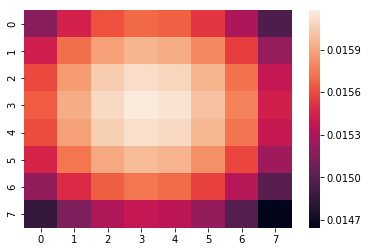

In [30]:
sns.heatmap(a)
plt.show()